# Week 3 Project: Histopathologic Cancer Detection

Neil Chen, University of Colorado Boulder

Mar 16, 2025




In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Environment Setup: Make sure that Tensorflow is using the correct GPU

I am using a Alienware x14 laptop for this project, with a `NVIDIA GeForce RTX 3060 Laptop GPU` installed. Operation system is Windows 11.

At first, when running the model, I saw from the Windows system's task manager that the Tensorflow seems not be using my Nvidia GPU, but instead it could be using another builtin video adapter called `Intel(R) Iris(R) Xe Graphics`, which is quite weak, so I tried for figure out how to configure Tensorflow to use my NVIDIA GeForce GPU.

The final workable software versions are the following:

- pyenv-win
- Python 3.10.5
- tensorflow 2.10.0
- CUDA 11.2.2
- cuDNN 8.1.1
- `numpy<2`

In [2]:
# Check GPU devices on the machine, and make sure that Tensorflow is using the NVIDIA RTX GPU.
import tensorflow as tf
from tensorflow.python.client import device_lib
import os

# logical_devices = tf.config.list_logical_devices('GPU')
# print('Logical Devices:\n', logical_devices)

# Enforce TensorFlow to only use the first GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Print usable devices
print('Devices:\n')
for d in device_lib.list_local_devices():
    print('Device:\n======================\n' + str(d))

# print(tf.sysconfig.get_build_info())

# Check GPU devices
gpus = tf.config.list_physical_devices('GPU')

print(len(gpus))
for gpu in gpus:
    # Enable on demand GPU memory allocation (suitable for training with desktop GPU)
    tf.config.experimental.set_memory_growth(gpu, True)
# Only use the first GPU
tf.config.set_visible_devices(gpus[0], 'GPU')

# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Devices:

Device:
name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1333607458921634639
xla_global_id: -1

Device:
name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3640655872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6299309711750738049
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419

1


### Test basic Tensorflow oprations with GPU

If it executes very fast, it means it is leveraging the GPU.

In [3]:
# Simple matrix multiplication task, to test whether the GPU is being used
x = tf.random.normal([10000, 10000])
y = tf.random.normal([10000, 10000])
z = tf.matmul(x, y)

In [4]:
# Another test on GPU
@tf.function
def test_fn():
    x = tf.random.normal([10000, 10000])
    y = tf.random.normal([10000, 10000])
    z = tf.matmul(x, y)
    return z

print(test_fn())

tf.Tensor(
[[ 132.16719    -36.806473  -137.81209   ...   -9.113752    62.380684
   -60.95663  ]
 [  52.127872   -20.732182  -104.331215  ...  -79.382095   163.14998
  -117.29108  ]
 [  68.45875     57.530178    90.83951   ...  -41.33518     95.45043
   164.98149  ]
 ...
 [ -52.185535     2.5300598   94.92572   ...  -62.3986     -21.123323
  -140.60179  ]
 [-123.52503    -74.9708    -166.95984   ...  -70.611404  -122.91708
    -4.300093 ]
 [-124.749756   -19.689026    33.882908  ...  -25.142494    34.69302
   188.19249  ]], shape=(10000, 10000), dtype=float32)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


## Exploratory Data Analysis (EDA)

In [6]:
train_labels = pd.read_csv('./histopathologic-cancer-detection/train_labels.csv')
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


### Check the first image

The result shows that every image has 96x96 pixels, with 3 channels for RGB.

In [7]:
id1 = train_labels.iloc[0,]['id']
image1 = Image.open('./histopathologic-cancer-detection/train/' + id1 + '.tif')
image1_array = np.array(image1)
print(image1_array.shape)
print(image1_array)

(96, 96, 3)
[[[246 246 244]
  [247 247 245]
  [249 248 246]
  ...
  [247 246 244]
  [247 246 244]
  [247 246 244]]

 [[243 243 241]
  [243 243 241]
  [246 245 243]
  ...
  [248 247 245]
  [247 246 244]
  [246 245 243]]

 [[244 244 242]
  [245 245 243]
  [247 246 244]
  ...
  [248 247 245]
  [247 246 244]
  [246 245 243]]

 ...

 [[172 127 156]
  [118  73 106]
  [ 90  49  81]
  ...
  [244 244 242]
  [242 242 240]
  [242 242 240]]

 [[135  87 127]
  [ 89  41  83]
  [133  88 131]
  ...
  [244 244 242]
  [243 243 241]
  [242 242 240]]

 [[145  93 141]
  [108  58 109]
  [131  84 136]
  ...
  [245 245 243]
  [243 243 241]
  [242 242 240]]]


### Render first 5 images to see how do they look like

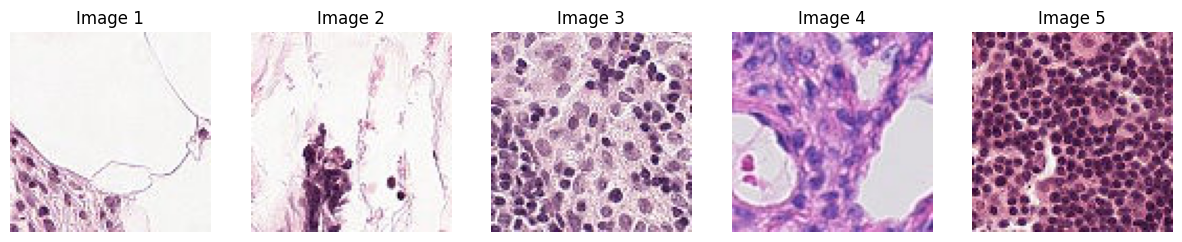

In [8]:
# type: train or test
def get_image(id, type):
    image = Image.open('./histopathologic-cancer-detection/' + type + '/' + id + '.tif')
    return image

# Show the first 5 images
plt.figure(figsize=(15, 5))
for i in range(5):
    id = train_labels.iloc[i,]['id']
    image = get_image(id, 'train')
    plt.subplot(1, 5, i+1)
    plt.imshow(image, cmap="gray" if image.mode == "L" else None)
    plt.axis("off")
    plt.title(f"Image {i+1}")

plt.show()

### Get the center 32x32 pixel region of an image

(Since only the center region is what we are required to predict upon, other surrounding areas of the image can be useful as paddings)

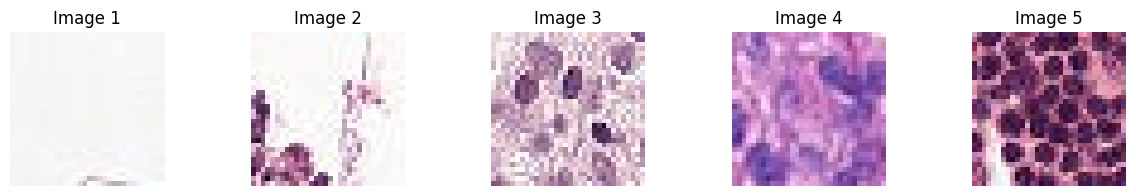

In [9]:
# Now we need to get the center 32x32px region of the image
def get_center_image(image):
    image_array = np.array(image)
    H, W = image_array.shape[:2]

    center_x, center_y = W // 2, H // 2
    start_x, start_y = center_x - 16, center_y - 16

    # extract the center 32x32px region
    cropped_image = image_array[start_y:start_y + 32, start_x:start_x + 32]
    return cropped_image

# Show the first 5 cropped images
plt.figure(figsize=(15, 2))
for i in range(5):
    id = train_labels.iloc[i,]['id']
    image = get_image(id, 'train')
    cropped = get_center_image(image)
    plt.subplot(1, 5, i+1)
    plt.imshow(cropped, cmap="gray")
    plt.axis("off")
    plt.title(f"Image {i+1}")

plt.show()

### Check the distribution of pixel values

Since there are too many images to process, we won't bother to check everyone of them.
Let's just take the first 100 sample images to check the pixel value distribution.


Mean: 165.28, Std: 64.37, Min: 0, Max: 255


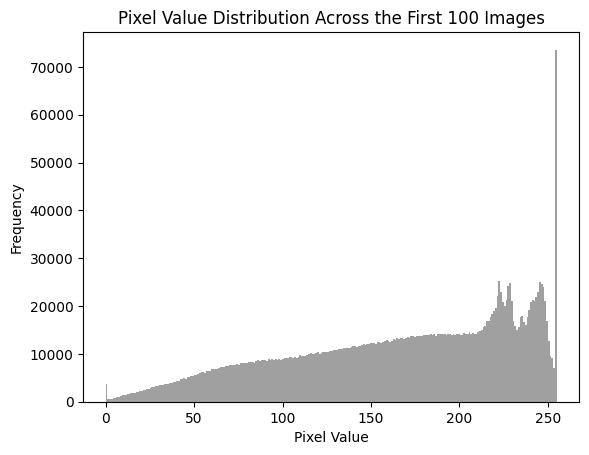

In [10]:
all_pixels = []

for i in range(100):
    id = train_labels.iloc[i,]['id']
    image = get_image(id, 'train')
    image_array = np.array(image)
    all_pixels.extend(image_array.flatten())

all_pixels = np.array(all_pixels)

# calculate statistics:
mean_pixel = np.mean(all_pixels)
std_pixel = np.std(all_pixels)
min_pixel = np.min(all_pixels)
max_pixel = np.max(all_pixels)

print(f"Mean: {mean_pixel:.2f}, Std: {std_pixel:.2f}, Min: {min_pixel}, Max: {max_pixel}")

plt.hist(all_pixels, bins=256, range=(0, 255), color='gray', alpha=0.75)
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.title("Pixel Value Distribution Across the First 100 Images")
plt.show()

From the above plot we see that pixel values are fairly distributed, no further preprocessing is needed.

## Build the model

We will design the CNN model as the following:

- Convolutional Layers
  - 32 3x3 filters to capture low level simple features, followed by a max pooling layer with stride=2 for dimension reduction
  - 64 3x3 filters to capture higher level features, followed by a max pooling layer with stride=2 for dimension reduction
  - 128 3x3 filters to capture advanced features, followed by a max pooling layer with stride=2 for dimension reduction
- Classification layers
  - 1 fully connected dense layer, with 128 neurons, to learn other high level (non-linear) features.
  - 1 dropout layer to prevent overfitting
  - 1 dense layer with only 1 neuron to predict the binary 'yes/no' output, with Sigmoid as the activation function.

For input, we have 2 choices:

- Use the original 96x96 image as the input
- Only use the 32x32 center region of the image (pre-cropped) as the input

Both have pros and cons, I will try with the cropped image input first.

In [14]:
# If we use 96x96 original image as the input
# input_shape=(96, 96, 3)

# If we use 32x32 center region as the input
input_shape=(32, 32, 3)

model = Sequential([
    # 3 convolution + pooling layers, with ReLU as the activation function
    # 32 3x3 filters
    # convolutional layer: to learn low level simple features
    Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
    # stride=2, for compression
    MaxPooling2D((2, 2)),

    # convolutional layer: learn more advanced features
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),

    # convolutional layer: learn even more advanced features
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),

    # flatten to connect with next hidden layer (for classification)
    Flatten(),

    # this layer is to learn other non-linear features
    Dense(128, activation="relu"),
    Dropout(0.5),  # to prevent overfitting
    Dense(1, activation="sigmoid")  # binary class classification
])

model.compile(optimizer=Adam(learning_rate=0.0002),
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

## Training

Here we split the input images into batches, because there are in total nearly 7 GB of the image data, it may not be possible to load them into a dataframe all together.

I try with batch size 64 first, and the corresponding learning rate is set to 0.0002.


In [15]:
def data_generator(df, batch_size):
    while True:
        for i in range(0, len(df), batch_size):
            batch_df = df[i:i + batch_size]
            X_batch, y_batch = [], []

            # Load all images for a batch
            for _, row in batch_df.iterrows():
                image = get_image(row['id'], 'train')
                image_cropped = get_center_image(image)
                X_batch.append(image_cropped)
                y_batch.append(row["label"])

            # Convert to numpy array
            X_batch = np.array(X_batch)
            y_batch = np.array(y_batch)

            # yield batch data
            yield X_batch, y_batch

train_df, val_df = train_test_split(train_labels, test_size=0.2, stratify=train_labels["label"], random_state=42)

batch_size = 64

train_gen = data_generator(train_df, batch_size=batch_size)
val_gen = data_generator(val_df, batch_size=batch_size)

model.fit(
    train_gen, 
    steps_per_epoch=len(train_df) // batch_size, 
    epochs=20, 
    validation_data=val_gen, 
    validation_steps=len(val_df) // batch_size
)


Epoch 1/20
2750/2750 [==============================] - 1830s 663ms/step - loss: 0.5795 - accuracy: 0.7414 - val_loss: 0.5086 - val_accuracy: 0.7553
Epoch 2/20
2750/2750 [==============================] - 1055s 384ms/step - loss: 0.5021 - accuracy: 0.7687 - val_loss: 0.4724 - val_accuracy: 0.7790
Epoch 3/20
2750/2750 [==============================] - 100s 37ms/step - loss: 0.4665 - accuracy: 0.7905 - val_loss: 0.4596 - val_accuracy: 0.7909
Epoch 4/20
2750/2750 [==============================] - 102s 37ms/step - loss: 0.4433 - accuracy: 0.8034 - val_loss: 0.4439 - val_accuracy: 0.7979
Epoch 5/20
2750/2750 [==============================] - 101s 37ms/step - loss: 0.4262 - accuracy: 0.8113 - val_loss: 0.4245 - val_accuracy: 0.8134
Epoch 6/20
2750/2750 [==============================] - 99s 36ms/step - loss: 0.4117 - accuracy: 0.8176 - val_loss: 0.4129 - val_accuracy: 0.8206
Epoch 7/20
2750/2750 [==============================] - 102s 37ms/step - loss: 0.3977 - accuracy: 0.8245 - val_loss

## Result Analysis

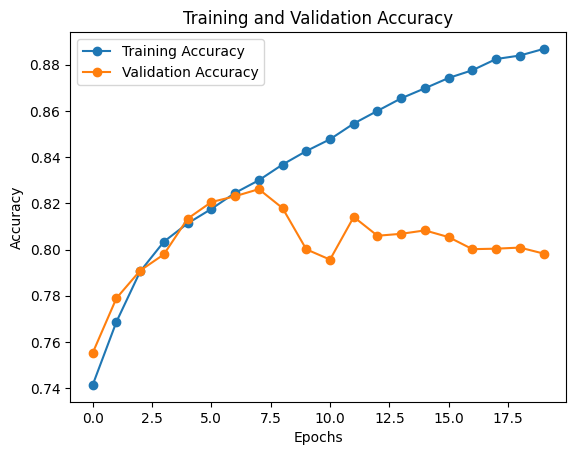

In [21]:
hist = model.history
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

epochs = range(len(acc))

# Plot training accuracy and validation accuracy
plt.plot(epochs, acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.show()

The result shows that, at around epoch 7, the model achieved best training and validation accuracy both at about `82.5%`.

After that, the model starts to overfit, with validation accuracy dropped.

To tackle this, we may try with a few approaches:

- Early stopping at epoch 7
- Try with a different input size (full picture)
- Adjust model design
- Tune hyperparamters
- I forgot to do image normalization, currently the pixel values are (0~255) ranged. Normalization may helps.

## Model Improvement and Hyper-Parameter Tuning

The accuracy we achieved are `82.5%`. Now we will try to improve the model by doing some tuning.

### Approaches

Considering the large dataset, the training time is too long, it's not very realistic for us to do thorough grid search based hyper-parameter tuning. So we will first do some obvious optimizations based on analysis of the above result, and maybe some random search on batch size and learning rate.

### Basic improvements

- Use the original image with input size 96x96.
- Added normalization
- Add more convolution filters, and one more layer: Change to use 64, 128, 256, 512 filters on each layer respectively.
- Try 0.0001 as the learning rate
- Increase batch size to 128 to train faster

In [11]:
model = Sequential([
    # 3 convolution + pooling layers, with ReLU as the activation function
    # 32 3x3 filters
    # convolutional layer: to learn low level simple features
    Conv2D(64, (3, 3), activation="relu", input_shape=(96, 96, 3)),
    # stride=2, for compression
    MaxPooling2D((2, 2)),

    # convolutional layer: learn more advanced features
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),

    # convolutional layer: learn even more advanced features
    Conv2D(256, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),

    # Add one more convolution layer + pooling layer
    Conv2D(512, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),

    # flatten to connect with next hidden layer (for classification)
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),  # to prevent overfitting
    Dense(1, activation="sigmoid")  # binary class classification
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 256)      0

In [ ]:
def data_generator(df, batch_size):
    while True:
        for i in range(0, len(df), batch_size):
            batch_df = df[i:i + batch_size]
            X_batch, y_batch = [], []

            # Load all images for a batch
            for _, row in batch_df.iterrows():
                # Use original image without cropping the center region,
                # and normalize it to 0 ~ 1 ranged
                image = get_image(row['id'], 'train')
                image_normalized = np.array(image.convert('RGB')) / 255.0
                X_batch.append(image_normalized)
                y_batch.append(row["label"])

            # Convert to numpy array
            X_batch = np.array(X_batch)
            y_batch = np.array(y_batch)

            # yield batch data
            yield X_batch, y_batch

train_df, val_df = train_test_split(train_labels, test_size=0.2, stratify=train_labels["label"], random_state=42)

batch_size = 128

train_gen = data_generator(train_df, batch_size=batch_size)
val_gen = data_generator(val_df, batch_size=batch_size)

early_stop = EarlyStopping(
    monitor='val_loss',  # monitoring validation loss
    patience=3,          # If it doesn't improve for 3 rounds, stop training
    restore_best_weights=True  # Restore to best epoch's weights
)

history = model.fit(
    train_gen, 
    steps_per_epoch=len(train_df) // batch_size, 
    epochs=20, 
    validation_data=val_gen, 
    validation_steps=len(val_df) // batch_size,
    callbacks=[early_stop] # Early stopping to prevent overfit and save some time
)

Epoch 1/20
1375/1375 [==============================] - 1957s 1s/step - loss: 0.4245 - accuracy: 0.8106 - val_loss: 0.3833 - val_accuracy: 0.8377
Epoch 2/20
1375/1375 [==============================] - 2727s 2s/step - loss: 0.3527 - accuracy: 0.8473 - val_loss: 0.3137 - val_accuracy: 0.8660
Epoch 3/20
1375/1375 [==============================] - 1116s 812ms/step - loss: 0.3046 - accuracy: 0.8726 - val_loss: 0.2752 - val_accuracy: 0.8852
Epoch 4/20
1375/1375 [==============================] - 182s 132ms/step - loss: 0.2673 - accuracy: 0.8913 - val_loss: 0.2542 - val_accuracy: 0.8955
Epoch 5/20
1375/1375 [==============================] - 152s 110ms/step - loss: 0.2377 - accuracy: 0.9055 - val_loss: 0.2224 - val_accuracy: 0.9125
Epoch 6/20
1375/1375 [==============================] - 157s 114ms/step - loss: 0.2145 - accuracy: 0.9161 - val_loss: 0.2053 - val_accuracy: 0.9193
Epoch 7/20
1375/1375 [==============================] - 150s 109ms/step - loss: 0.1937 - accuracy: 0.9254 - val_los

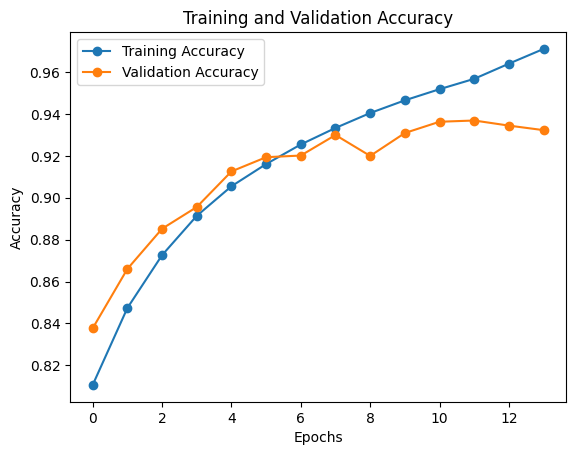

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

# Plot training accuracy and validation accuracy
plt.plot(epochs, acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.show()

### Result Analysis

Now we see that the improved model trained with validation accurary at around `93%`, at epoch 10.

Following that the validation accuracy drops and validation loss increases, meaning overfit.

And then the `EarlyStopping` strategy detected the validation loss has not improve for 3 epochs, and it stopped early to avoid overfitting.



## Save the model for future use

Now I'll save the model to a file so that it can be easily loaded, without worrying about Jupyter Notebook kernel restart, or computer restart etc.

In [ ]:
# Save weights only
model.save_weights('cnn_cancer_detection_weights.h5')

In [ ]:
# We can also save the full model
model.save('cnn_cancer_detection_full.h5')

## Predict on test dataset

Now let's apply the model to predict on test dataset, and generate the submission file.

In [21]:
# Read all the test file names and put them into a data frame
test_ids = []
for f in os.listdir('./histopathologic-cancer-detection/test/'):
    if f.endswith('.tif'):
        test_ids.append(f[:-4])

print(len(test_ids))

57458


In [24]:
# Preprocess the test images, and do predictions
# Since there are too many images, let's do it in batches
batch_size = 32
preds = []

for i in range(0, len(test_ids), batch_size):
    batch_ids = test_ids[i:i+batch_size]

    batch_images = []
    for test_id in batch_ids:
        test_img = Image.open('./histopathologic-cancer-detection/test/' + str(test_id) + '.tif')
        test_img = np.array(test_img.convert('RGB')) / 255.0
        batch_images.append(test_img)
    X_batch = np.array(batch_images)

    # predict
    batch_preds = model.predict(X_batch)
    preds.extend(batch_preds.flatten())

test_labels = (np.array(preds) > 0.5).astype(int)

# Generate submission file
submit_df = pd.DataFrame({
    "id": test_ids,
    "label": test_labels
})
submit_df.to_csv("submission.csv", index=False)

1/1 [==============================] - 0s 443ms/step


## Summary

In this project I created a CNN model to train the histopathologic cancer detection image dataset.
With the initial design of the model, it achieved `82.5%` accuracy and then overfits.

Then with a few improvements and hyper-parameter tuning the model's validation accuracy improved to `93%`, which I think is fairly good for this exercise.

Then predict the test data results in a `86.6%` public score.

What I learnt from this project:

- With more convolutional layers and filters the model can learn more complex features, most likely can improve accuracy.
- For large dataset, it's important to train it in batches to avoid OOM.
- Normalization of the input data is very important.
- Apply early stopping strategy to avoid overfitting.


